## Rádios e Faixas

**Objetivo:** classificar rádios e faixas por gênero.

A abordagem sendo atualmente tentada é caracterizar cada rádio pela quantidade de vezes que ela toca cada música e realizar um agrupamento (clusterização) das rádios. Primeiro os dados são explorados, filtrados e algumas hipóteses são levantadas. Em seguida uma modelagem é feita de acordo com essa hipótese e então ela é testada. Os testes sugerem novas ideias e melhorias, tornando o processo iterativo.

Diversas tentativas foram feitas, nas quais um problema frequentemente encontrado foi a existência de clusters com 1 ou algumas poucas (menos que 10) rádios. Assim, pode ser procurado um critério de limpeza dos dados que elimine essas rádios espúrias para não contaminar o modelo, antes de se passar a outra abordagem completamente diferente.

### Análise exploratória

Estrutura do arquivo

In [1]:
import pandas as pd

detections = pd.read_csv('detections.csv')
detections.head()

,created_at,audio_source_id,track_id
0,2019-08-20 00:00:01,10473,585767
1,2019-08-20 00:00:01,2434,936762
2,2019-08-20 00:00:01,11215,813162
3,2019-08-20 00:00:01,11416,1747
4,2019-08-20 00:00:02,10487,1417735


Execuções por rádio

In [2]:
per_radio = detections.groupby('audio_source_id').agg({'created_at': 'count'})
per_radio.rename(columns={'created_at': 'execution_count'}, inplace=True)
per_radio.execution_count.describe()

count    5957.000000
mean      986.989760
std       646.876581
min         1.000000
25%       461.000000
50%       921.000000
75%      1427.000000
max      3371.000000
Name: execution_count, dtype: float64

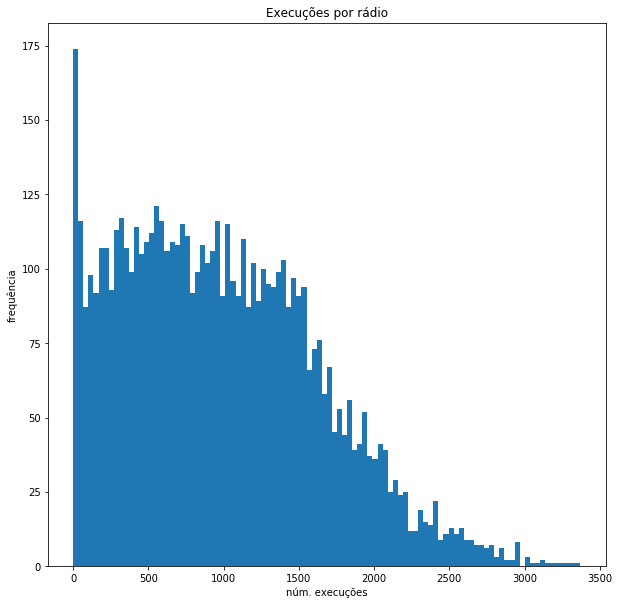

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
plt.title('Execuções por rádio')
plt.xlabel('núm. execuções')
plt.ylabel('frequência')
plt.hist(per_radio.execution_count, bins=100)
plt.show()

Existem rádios com uma quantidade muito baixa de execuções, convém olhá-las mais de perto

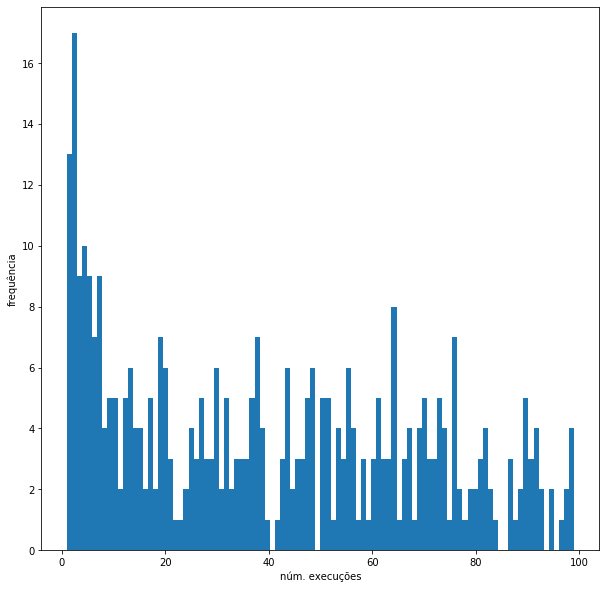

In [5]:
selected = per_radio[per_radio.execution_count < 100]
plt.figure(figsize=(10, 10))
plt.xlabel('núm. execuções')
plt.ylabel('frequência')
plt.hist(selected.execution_count, bins=100)
plt.show()

Algumas rádios foram muito pouco amostradas, a partir de cerca de 10 execuções o padrão muda bruscamente.
* **Hipótese**: são estas as rádios que ficam isoladas em seus clusters sem outas rádios? Vamos eliminá-las!

Execuções por música:

In [6]:
per_track = detections.groupby('track_id').agg({'created_at': 'count'})
per_track.rename(columns={'created_at': 'execution_count'}, inplace=True)
per_track.execution_count.describe()

count    211661.000000
mean         27.777900
std         203.764816
min           1.000000
25%           1.000000
50%           3.000000
75%          12.000000
max       20856.000000
Name: execution_count, dtype: float64

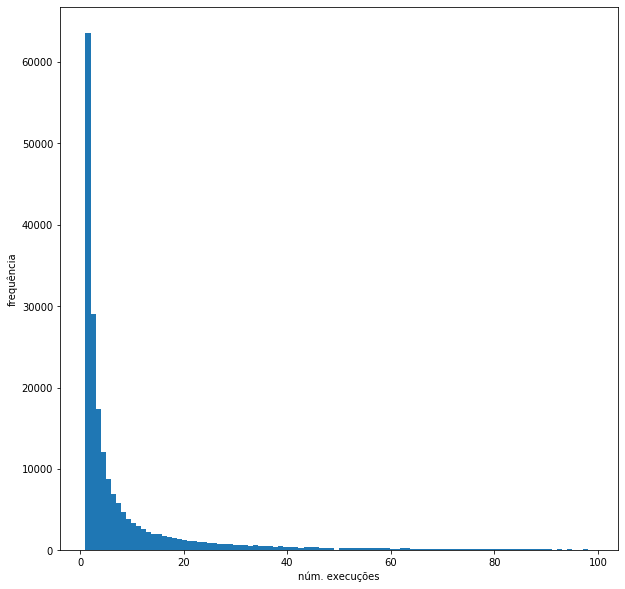

In [7]:
selected = per_track[per_track.execution_count < 100]
plt.figure(figsize=(10, 10))
plt.xlabel('núm. execuções')
plt.ylabel('frequência')
plt.hist(selected.execution_count, bins=100)
plt.show()

As músicas são executadas de forma bastante desigual!
* Uma música que é executada apenas 1 vez não deve ser tão relevante para agrupar as rádios 
  * é preciso que a música seja comum entre várias rádios.
* Aqui, também uma limpeza pode ser feita!

### Há clusters visíveis?
Contando as ocorrências dos pares `(radio, música)`

In [8]:
grouped = detections.groupby(['audio_source_id', 'track_id'], as_index=False).agg({'created_at': 'count'})
grouped.rename(columns={'created_at': 'execution_count'}, inplace=True)
grouped.execution_count.describe()

count    3.337244e+06
mean     1.761782e+00
std      3.412736e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.035000e+03
Name: execution_count, dtype: float64

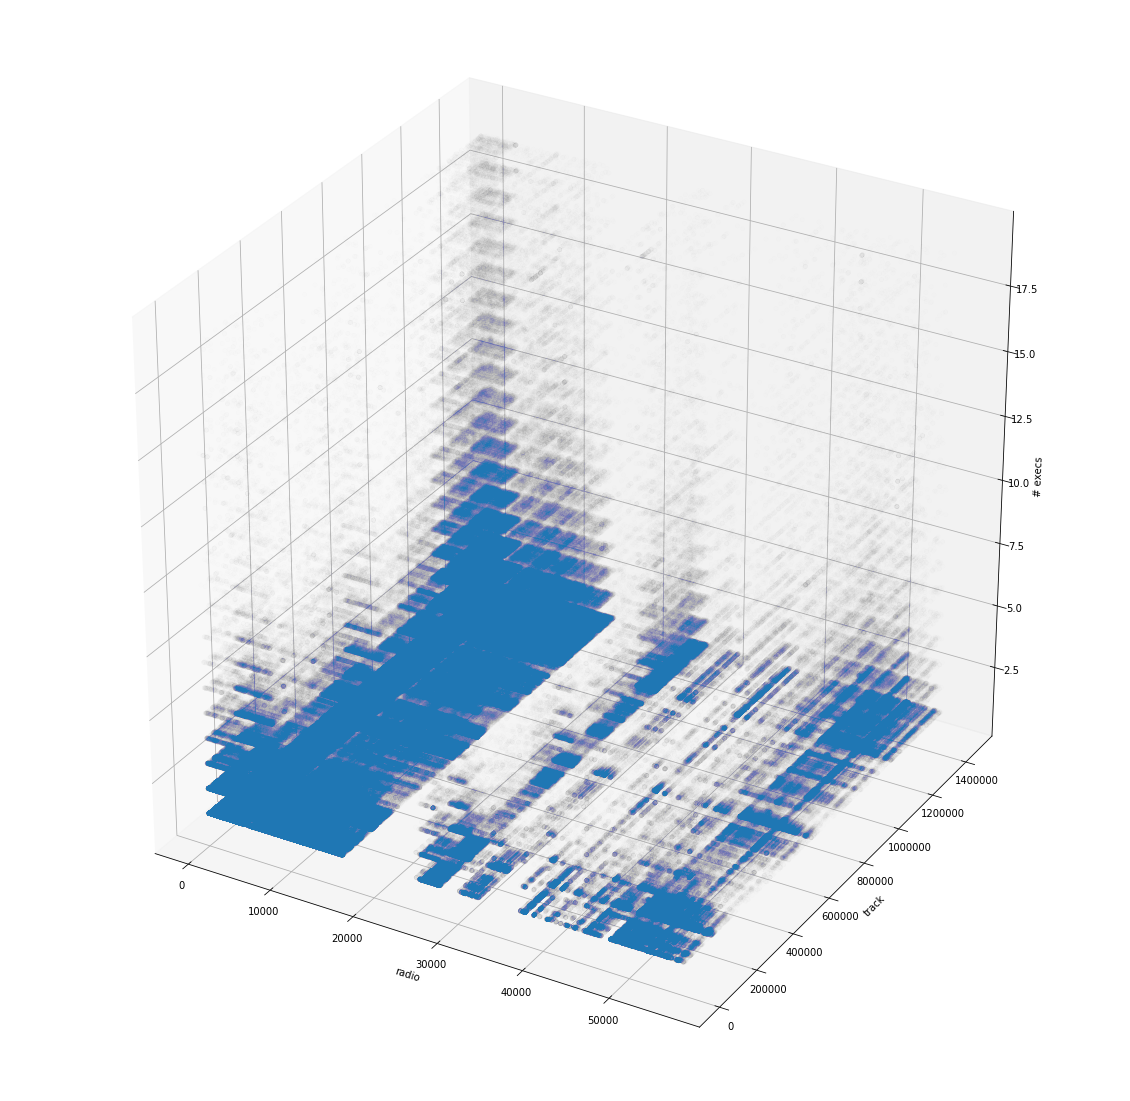

In [9]:
from mpl_toolkits.mplot3d import Axes3D

selected = grouped[grouped.execution_count < 20]
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('radio')
ax.set_ylabel('track')
ax.set_zlabel('# execs')
ax.scatter(selected.audio_source_id, selected.track_id, selected.execution_count, alpha=0.005)
plt.show()

A base de dados já parece trazer as músicas e rádios agrupadas de alguma maneira coerente. Não se pode tomar os IDs como valores, e sim como categorias.

Os primeiros IDs de rádios parecem ser mais genéricos, ou seja, tocam de tudo. Os _hits_ parecem se concentrar entre as músicas com maiores valores de ID. São muito tocados nas primeiras rádios, mas outras também tocam esses hits mais que as outras músicas.

### Agrupamento das rádios

Selecionamos músicas e rádios minimamente representativas 
* Músicas que executaram em ao menos 10 rádios
* Rádios que executaram ao menos 10 músicas

In [11]:
threshold = 10
selected_tracks = pd.DataFrame(per_track[per_track.execution_count >= threshold].index)
selected_radios = pd.DataFrame(per_radio[per_radio.execution_count >= threshold].index)
selected_samples = grouped.merge(selected_tracks, on='track_id').merge(selected_radios, on='audio_source_id')
print(len(selected_samples), 'pares (rádio, música)')
selected_samples.head()

2997372 pares (rádio, música)


,audio_source_id,track_id,execution_count
0,1,3233,1
1,1,3341,1
2,1,3541,1
3,1,3665,1
4,1,3729,2


As características ou _features_ serão o número de vezes que cada música é executada

In [12]:
unstacked = selected_samples.groupby(['audio_source_id', 'track_id']).sum().unstack()
unstacked.fillna(0, inplace=True)
unstacked.head()

execution_count                                          \
track_id                1       7       8       9       16      18        
audio_source_id                                                           
1                           0.0     0.0     0.0     0.0     0.0     0.0   
2                           0.0     0.0     0.0     1.0     0.0     0.0   
3                           0.0     0.0     0.0     0.0     0.0     0.0   
5                           0.0     0.0     0.0     0.0     0.0     0.0   
6                           0.0     0.0     0.0     0.0     0.0     0.0   

                                                 ...                          \
track_id        23      26      27      29       ... 1453320 1453324 1453325   
audio_source_id                                  ...                           
1                   0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2                   0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0   
3                   0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0   
5                   0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0   
6                   0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0   

                                                                         
track_id        1453326 1453328 1453334 1453337 1453352 1453372 1453379  
audio_source_id                                                          
1                   0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2                   0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3                   0.0     0.0     0.0     0.0     0.0     0.0     0.0  
5                   0.0     0.0     0.0     0.0     0.0     1.0     1.0  
6                   0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 59484 columns]

**"Método do cotovelo":** determinar uma quantidade ideal de clusters

In [ ]:
from sklearn.cluster import KMeans

wcss = []
models = {}
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(unstacked)
    models[i] = kmeans
    wcss.append(kmeans.inertia_)

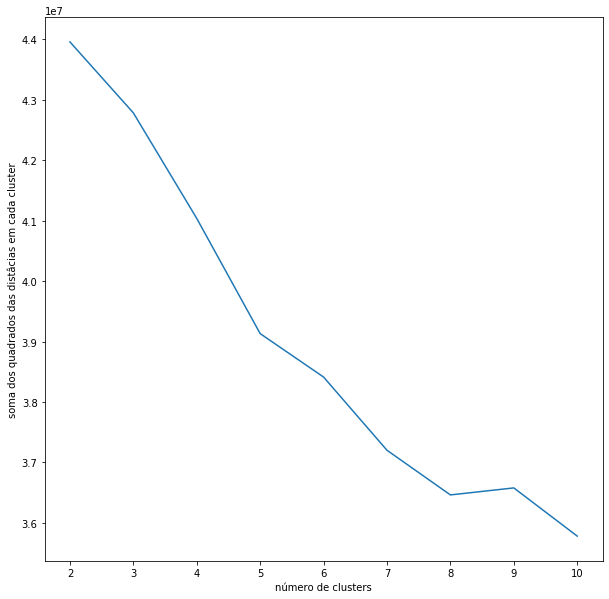

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(range(2, 11), wcss)
plt.xlabel('número de clusters')
plt.ylabel('soma dos quadrados das distâcias em cada cluster')
plt.show()

### Analisando o resultado

A curva não tem bem um formato de "cotovelo", indicando que essa clusterização ainda está um pouco pobre, sem grandes ganhos a cada aumento na quantidade de clusters.

Inspecionando quantas rádios existem em cada categoria, para cada clusterização:
* Independentemente da quantidade de clusters, as separações encontram poucos grupos significativos e algumas rádios ficam isoladas

2 clusters


,radio_count
radio_label,
0,5869
1,1


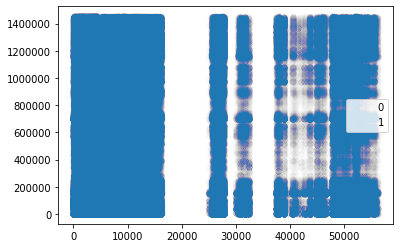

3 clusters


,radio_count
radio_label,
0,5340
1,1
2,529


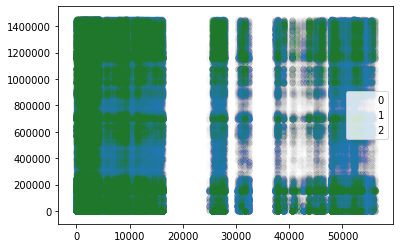

4 clusters


,radio_count
radio_label,
0,529
1,7
2,5333
3,1


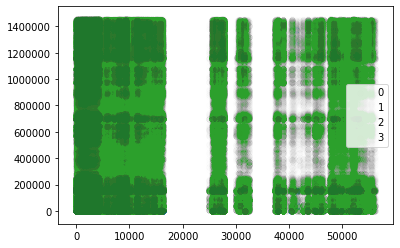

5 clusters


,radio_count
radio_label,
0,4573
1,968
2,1
3,327
4,1


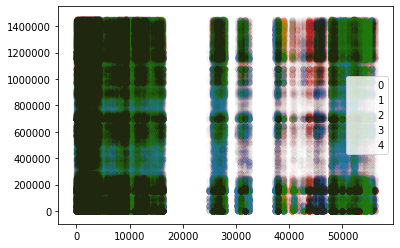

6 clusters


,radio_count
radio_label,
0,66
1,1
2,1
3,966
4,4513
5,323


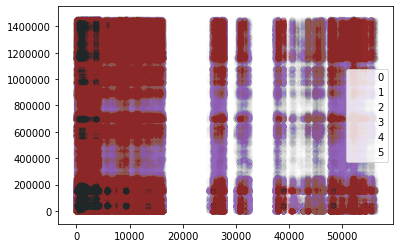

7 clusters


,radio_count
radio_label,
0,5336
1,1
2,5
3,1
4,525
5,1
6,1


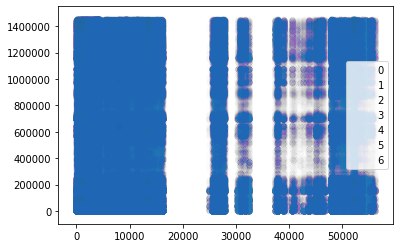

8 clusters


,radio_count
radio_label,
0,3
1,1
2,977
3,1
4,4556
5,1
6,1
7,330


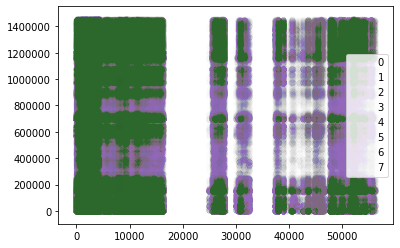

9 clusters


,radio_count
radio_label,
0,524
1,5
2,1
3,1
4,1
5,1
6,1
7,5276
8,60


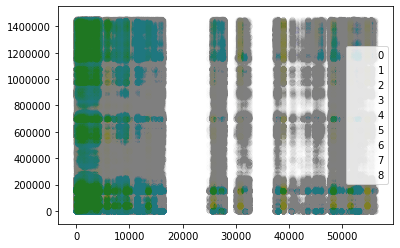

10 clusters


,radio_count
radio_label,
0,5314
1,54
2,1
3,1
4,1
5,1
6,495
7,1
8,1


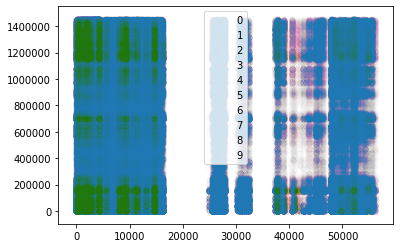

In [17]:
for i in range(2, 11):
    print(i, 'clusters')
    labels = pd.DataFrame({'audio_source_id': unstacked.index, 'radio_label':  models[i].labels_})
    countings = labels.groupby('radio_label').agg({'audio_source_id': 'count'})
    countings.rename(columns={'audio_source_id': 'radio_count'}, inplace=True)
    display(countings)
    
    grouped_with_labels = grouped.merge(labels, on='audio_source_id')
    plt.figure()
    for j in range(i):
        filtered = grouped_with_labels[grouped_with_labels.radio_label == j]
        plt.scatter(filtered.audio_source_id, filtered.track_id, alpha=0.005, label=j)
    plt.legend()
    plt.show()

### Saída

A divisão em 6 clusters identificou 4 grupos significativos, os quais parecem melhor refletir o padrão visto no scatterplot 3D mais acima.
* A divisão em 9 clusters também não parece ruim, mas encontrou apenas 3 grupos significativos

In [18]:
def text_label(label):
    if label == 0:
        return 'gender1'
    elif label == 3:
        return 'gender2'
    elif label == 4:
        return 'gender3'
    elif label == 5:
        return 'gender4'
    else:
        return 'unknown'

selected = 6
labels = pd.DataFrame({'audio_source_id': unstacked.index, 'radio_label':  models[selected].labels_})
labels.radio_label = labels.radio_label.apply(text_label)
labels.head()

,audio_source_id,radio_label
0,1,gender3
1,2,gender4
2,3,gender3
3,5,gender3
4,6,gender3


In [19]:
labels.to_csv('radio-classification.csv', index=False, sep='|')